In [1]:
import numpy as np
import pyedflib

In [2]:
def LoadBDF(bdf_file, name = "EXG2", start = None, end = None):
    with pyedflib.EdfReader(bdf_file) as f:
        status_index = f.getSignalLabels().index('Status')
        sample_frequency = f.samplefrequency(status_index)
        status_size = f.samples_in_file(status_index)
        status = np.zeros((status_size, ), dtype = 'float64')
        f.readsignal(status_index, 0, status_size, status)
        status = status.round().astype('int')
        nz_status = status.nonzero()[0]

        video_start = nz_status[0]
        video_end = nz_status[-1]

        index = f.getSignalLabels().index(name)
        sample_frequency = f.samplefrequency(index)

        video_start_seconds = video_start / sample_frequency

        if start is not None:
            start += video_start_seconds
            start *= sample_frequency
            if start < video_start:
                start = video_start
            start = int(start)
        else:
            start = video_start
        
        if end is not None:
            end += video_start_seconds
            end *= sample_frequency
            if end > video_end:
                end = video_end
            end = int(end)
        else:
            end = video_end
        
        PhysicalMax = f.getPhysicalMaximum(index)
        PhysicalMin = f.getPhysicalMinimum(index)
        DigitalMax = f.getDigitalMaximum(index)
        DigitalMin = f.getDigitalMinimum(index)

        scale_factor = (PhysicalMax - PhysicalMin) / (DigitalMax - DigitalMin)
        dc = PhysicalMax - scale_factor * DigitalMax

        container = np.zeros((end - start, ), dtype = 'float64')
        f.readsignal(index, start, end - start, container)
        container = container * scale_factor + dc

        return container, sample_frequency

In [9]:
container, sample_frequency = LoadBDF("../dataset/hci/1/Part_1_N_Trial1_emotion.bdf",name = "Fp1")

In [10]:
container.shape

(5164,)

## GSR 皮肤电信号

In [11]:
container, sample_frequency = LoadBDF("../dataset/hci/1/Part_1_N_Trial1_emotion.bdf",name = "GSR1")

In [12]:
container.shape

(5164,)

In [17]:
np.average(container)

2900.1315394393882

In [21]:
container[container<0].shape

(0,)

## Status

### 可以通过状态Status通道看什么时候刺激开始

In [30]:
container, sample_frequency = LoadBDF("../dataset/hci/1/Part_1_N_Trial1_emotion.bdf",name = "Status")

In [31]:
container

array([500000.48192777, 500000.48192777, 500000.48192777, ...,
       500000.48192777, 500000.48192777, 500000.48192777])

In [32]:
import matplotlib.pyplot as plt

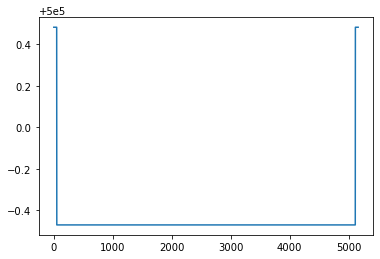

In [33]:
plt.plot(container)

In [34]:
container.shape

(5164,)

## EEG

In [88]:
chan_left_list = ["Fp1","AF3","F3","F7","FC1","FC5","T7","C3","CP1","CP5","P7","P3","PO3","O1"]
chan_right_list = ["Fp2","AF4","F4","F8","FC2","FC6","T8","C4","CP2","CP6","P8","P4","PO4","O2"]
chan_else_list = ["Fz","Cz","Pz","Oz"]

In [77]:
fp1_data, sample_frequency = LoadBDF("../dataset/hci/1/Part_1_N_Trial1_emotion.bdf",name = "Fp1")

In [78]:
fp1_data

array([-400.14158953, -400.15623791, -400.07225385, ..., -399.82127822,
       -399.77635651, -399.77830962])

In [79]:
sample_frequency

256.0

In [85]:
# 信号处理
from scipy import signal
from scipy.fftpack import fft,ifft,fftshift
from scipy.signal import welch

# 获得指定频率功率谱密度/功率谱
# option=='ps'是功率谱， psd是功率谱密度
def bandpower(f, Pxx, fmin, fmax, option="ps"):
    ind_min = np.argmax(f > fmin) - 1
    ind_max = np.argmax(f > fmax) - 1
    if option=='ps':
        return Pxx[ind_min: ind_max]
    if option=='psd':
        return Pxx[ind_min: ind_max].mean()

## 获取指定频率范围的功率谱，并展开成向量    
def get_freq_band_ps(low, high, data, fs):
    f, Pxx = welch(data, fs=fs)
    power_spectrum = bandpower(f, Pxx, low, high, option="psd");
    return power_spectrum

In [86]:
get_freq_band_ps(0.5, 30, fp1_data, sample_frequency)

0.011023240424900806

In [89]:
eeg_feature = []
for i in np.arange(14):
    if i<4:
        data1, fs1 = LoadBDF("../dataset/hci/1/Part_1_N_Trial1_emotion.bdf",name=chan_else_list[i])
        eeg_feature.append(get_freq_band_ps(4, 8, data1, fs1))  ## theta
        eeg_feature.append(get_freq_band_ps(8, 10, data1, fs1)) ## slow alpha
        eeg_feature.append(get_freq_band_ps(8, 12, data1, fs1)) ## alpha
        eeg_feature.append(get_freq_band_ps(12, 30, data1, fs1)) ## beta
        eeg_feature.append(get_freq_band_ps(30, 50, data1, fs1)) ## gamma
    data2, fs2 = LoadBDF("../dataset/hci/1/Part_1_N_Trial1_emotion.bdf",name=chan_left_list[i])
    eeg_feature.append(get_freq_band_ps(4, 8, data2, fs2))  ## theta
    eeg_feature.append(get_freq_band_ps(8, 10, data2, fs2)) ## slow alpha
    eeg_feature.append(get_freq_band_ps(8, 12, data2, fs2)) ## alpha
    eeg_feature.append(get_freq_band_ps(12, 30, data2, fs2)) ## beta
    eeg_feature.append(get_freq_band_ps(30, 50, data2, fs2)) ## gamma
    data3, fs3 = LoadBDF("../dataset/hci/1/Part_1_N_Trial1_emotion.bdf",name=chan_right_list[i])
    eeg_feature.append(get_freq_band_ps(4, 8, data3, fs3))  ## theta
    eeg_feature.append(get_freq_band_ps(8, 10, data3, fs3)) ## slow alpha
    eeg_feature.append(get_freq_band_ps(8, 12, data3, fs3)) ## alpha
    eeg_feature.append(get_freq_band_ps(12, 30, data3, fs3)) ## beta
    eeg_feature.append(get_freq_band_ps(30, 50, data3, fs3)) ## gamma
    eeg_feature.append(get_freq_band_ps(4, 8, data3, fs3)-get_freq_band_ps(4, 8, data2, fs2))
    eeg_feature.append(get_freq_band_ps(8, 12, data3, fs3)-get_freq_band_ps(8, 12, data2, fs2))
    eeg_feature.append(get_freq_band_ps(12, 30, data3, fs3)-get_freq_band_ps(12, 30, data2, fs2))
    eeg_feature.append(get_freq_band_ps(30, 50, data3, fs3)-get_freq_band_ps(30, 50, data2, fs2))

In [98]:
eeg_feature

[0.002062440960289711,
 0.0006379523101839985,
 0.0006999654676620312,
 0.00013100239999406575,
 3.9968278857952145e-05,
 0.012265100410623044,
 0.0015334355861360797,
 0.0014304826913718446,
 0.00023417510904610587,
 6.113459201999596e-05,
 0.014486233389874622,
 0.0021123675114255325,
 0.0017321604006114986,
 0.00024640549215566035,
 8.417164658666476e-05,
 0.002221132979251578,
 0.00030167770923965396,
 1.223038310955448e-05,
 2.30370545666688e-05,
 0.00023268760093207903,
 0.00016854506930686058,
 0.0002005198869228936,
 4.0107199430076424e-05,
 2.5208795634846994e-05,
 0.004760413940957167,
 0.0008479210463641629,
 0.0008096822471650635,
 0.00016413113677208086,
 4.5075500494811276e-05,
 0.006441212958461243,
 0.0013538232702251373,
 0.001244870411678753,
 0.00022945305495190846,
 8.504103996354844e-05,
 0.0016807990175040756,
 0.00043518816451368954,
 6.53219181798276e-05,
 3.996553946873716e-05,
 0.003681346172806823,
 0.001846890806197004,
 0.0017132921610143298,
 0.00055438356

In [97]:
len(eeg_feature)

216

In [99]:
def get_eeg_feature(eeg_path):
    chan_left_list = ["Fp1","AF3","F3","F7","FC1","FC5","T7","C3","CP1","CP5","P7","P3","PO3","O1"]
    chan_right_list = ["Fp2","AF4","F4","F8","FC2","FC6","T8","C4","CP2","CP6","P8","P4","PO4","O2"]
    chan_else_list = ["Fz","Cz","Pz","Oz"]
    
    eeg_feature = []
    for i in np.arange(14):
        if i<4:
            data1, fs1 = LoadBDF(path,name=chan_else_list[i])
            eeg_feature.append(get_freq_band_ps(4, 8, data1, fs1))  ## theta
            eeg_feature.append(get_freq_band_ps(8, 10, data1, fs1)) ## slow alpha
            eeg_feature.append(get_freq_band_ps(8, 12, data1, fs1)) ## alpha
            eeg_feature.append(get_freq_band_ps(12, 30, data1, fs1)) ## beta
            eeg_feature.append(get_freq_band_ps(30, 50, data1, fs1)) ## gamma
        data2, fs2 = LoadBDF(path,name=chan_left_list[i])
        eeg_feature.append(get_freq_band_ps(4, 8, data2, fs2))  ## theta
        eeg_feature.append(get_freq_band_ps(8, 10, data2, fs2)) ## slow alpha
        eeg_feature.append(get_freq_band_ps(8, 12, data2, fs2)) ## alpha
        eeg_feature.append(get_freq_band_ps(12, 30, data2, fs2)) ## beta
        eeg_feature.append(get_freq_band_ps(30, 50, data2, fs2)) ## gamma
        data3, fs3 = LoadBDF(path,name=chan_right_list[i])
        eeg_feature.append(get_freq_band_ps(4, 8, data3, fs3))  ## theta
        eeg_feature.append(get_freq_band_ps(8, 10, data3, fs3)) ## slow alpha
        eeg_feature.append(get_freq_band_ps(8, 12, data3, fs3)) ## alpha
        eeg_feature.append(get_freq_band_ps(12, 30, data3, fs3)) ## beta
        eeg_feature.append(get_freq_band_ps(30, 50, data3, fs3)) ## gamma
        eeg_feature.append(get_freq_band_ps(4, 8, data3, fs3)-get_freq_band_ps(4, 8, data2, fs2))
        eeg_feature.append(get_freq_band_ps(8, 12, data3, fs3)-get_freq_band_ps(8, 12, data2, fs2))
        eeg_feature.append(get_freq_band_ps(12, 30, data3, fs3)-get_freq_band_ps(12, 30, data2, fs2))
        eeg_feature.append(get_freq_band_ps(30, 50, data3, fs3)-get_freq_band_ps(30, 50, data2, fs2))
    return eeg_feature

## load_data

In [35]:
import numpy as np

In [43]:
for i in np.arange(2,41,2):
    path = "../dataset/hci/"+str(i)+"/Part_1_S_Trial"+str(int(i/2))+"_emotion.bdf"
    container, sample_frequency = LoadBDF(path,name = "Fp1")

In [45]:
container.size

22357

In [48]:
sample_frequency

256.0

In [49]:
import pandas as pd

In [50]:
label_data = pd.read_csv("../dataset/hci/1/P1-Rec1-Guide-Cut.tsv", sep="\t")

In [51]:
label_data

,AudioSampleNumber,Action,Name,AudioSampleCut,VideoFrameCut
0,224994,MovieStart,colorbars_Final.avi,224385.5,262.5
1,1183575,MovieEnd,colorbars_Final.avi,1264359.5,1583.5
2,1265126,MovieStart,69.avi,1264359.5,1583.5
3,2860816,LeftMouseClick,NaN,NaN,NaN
4,2933570,LeftMouseClick,NaN,NaN,NaN
...,...,...,...,...,...
379,133957406,KeyPress,D7,NaN,NaN
380,133958211,InstructionEnd,Dominance assessment,NaN,NaN
381,133970201,InstructionStart,Predictability assessment,NaN,NaN
382,134083747,KeyPress,D9,NaN,NaN


In [56]:
label_data2 = label_data[label_data['Action']=="KeyPress"].Name

In [65]:
np.asarray(label_data2).reshape(-1,5)
## 5个维度分别是：Emotion keyword、Arousal assessment、Valence assessment、Dominance assessment、Predictability assessment

array([['D3', 'D4', 'D3', 'D1', 'D5'],
       ['D8', 'D6', 'D3', 'D1', 'D7'],
       ['D2', 'D8', 'D9', 'D5', 'D5'],
       ['D5', 'D7', 'D5', 'D3', 'D1'],
       ['D4', 'D6', 'D3', 'D9', 'D2'],
       ['D7', 'D8', 'D2', 'D2', 'D1'],
       ['D5', 'D6', 'D8', 'D3', 'D3'],
       ['D2', 'D4', 'D7', 'D4', 'D5'],
       ['D9', 'D9', 'D2', 'D2', 'D6'],
       ['D5', 'D3', 'D6', 'D6', 'D5'],
       ['D8', 'D9', 'D4', 'D5', 'D5'],
       ['D1', 'D7', 'D3', 'D7', 'D5'],
       ['D7', 'D7', 'D2', 'D2', 'D7'],
       ['D1', 'D6', 'D3', 'D1', 'D9'],
       ['D2', 'D6', 'D5', 'D6', 'D7'],
       ['D1', 'D6', 'D2', 'D1', 'D8'],
       ['D4', 'D2', 'D5', 'D5', 'D6'],
       ['D5', 'D7', 'D7', 'D3', 'D7'],
       ['D4', 'D6', 'D6', 'D3', 'D6'],
       ['D5', 'D8', 'D8', 'D7', 'D9']], dtype=object)

In [67]:
label_data3 = np.asarray(label_data2).reshape(-1,5)

In [69]:
len(label_data3)

20

In [71]:
arousal_label_map = []
for i in np.arange(len(label_data3)):
    if(label_data3[i][0]=='D1' or label_data3[i][0]=='D3' or label_data3[i][0]=='D4'):
        arousal_label_map.append(0) ## Calm
    elif(label_data3[i][0]=='D2' or label_data3[i][0]=='D5'):
        arousal_label_map.append(1) ## Medium arousal
    elif(label_data3[i][0]=='D8' or label_data3[i][0]=='D7' or label_data3[i][0]=='D6' or label_data3[i][0]=='D9'):
        arousal_label_map.append(2)  ## Excited/Activated

In [72]:
arousal_label_map

[0, 2, 1, 1, 0, 2, 1, 1, 2, 1, 2, 0, 2, 0, 1, 0, 0, 1, 0, 1]

In [121]:
valence_label_map = []
for i in np.arange(len(label_data3)):
    if(label_data3[i][0]=='D7' or label_data3[i][0]=='D6' or label_data3[i][0]=='D1' or label_data3[i][0]=='D9' or label_data3[i][0]=='D3'):
        valence_label_map.append(0) ## Unpleasant
    elif(label_data3[i][0]=='D8' or label_data3[i][0]=='D4'):
        valence_label_map.append(1) ## Neutral valence
    elif(label_data3[i][0]=='D2' or label_data3[i][0]=='D5'):
        valence_label_map.append(2)  ## pleasant

In [122]:
valence_label_map

[0, 1, 2, 2, 1, 0, 2, 2, 0, 2, 1, 0, 0, 0, 2, 0, 1, 2, 1, 2]

## svm模型训练

In [131]:
def norm_feature(feature_data):
    max_data = np.max(feature_data)
    min_data = np.min(feature_data)
    return (feature_data-min_data)/(max_data-min_data)

In [148]:
train_data = []
for i in np.arange(2,41,2):
    path = "../dataset/hci/"+str(i)+"/Part_1_S_Trial"+str(int(i/2))+"_emotion.bdf"
    feature_data = get_eeg_feature(path)
#     norm_feature_data = norm_feature(feature_data)
#     train_data.append(norm_feature_data)
    train_data.append(feature_data)

In [149]:
np.asarray(train_data).shape

(20, 216)

In [150]:
np.asarray(arousal_label_map).shape

(20,)

In [151]:
final_data = np.asarray(train_data)

In [152]:
final_arousal_label = np.asarray(arousal_label_map)

In [153]:
final_valence_label = np.asarray(valence_label_map)

In [154]:
from sklearn.model_selection import KFold
from sklearn import svm

In [155]:
kf = KFold(n_splits=20)

In [156]:
pred_right = 0
for train_index, test_index in kf.split(final_data):
    X_train, X_test = final_data[train_index], final_data[test_index]
    Y_train, Y_test = final_arousal_label[train_index], final_arousal_label[test_index]
    clf = svm.SVC()
    clf.fit(X_train, Y_train)
    pred = clf.predict(X_test)
    acc = sum(pred == Y_test) / len(pred);
    pred_right += acc
    print(acc)
print(pred_right/20)

0.0
0.0
1.0
1.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
0.4


In [157]:
pred_right = 0
for train_index, test_index in kf.split(final_data):
    X_train, X_test = final_data[train_index], final_data[test_index]
    Y_train, Y_test = final_valence_label[train_index], final_valence_label[test_index]
    clf = svm.SVC()
    clf.fit(X_train, Y_train)
    pred = clf.predict(X_test)
    acc = sum(pred == Y_test) / len(pred);
    pred_right += acc
    print(acc)
print(pred_right/20)

0.0
0.0
1.0
1.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
0.4
